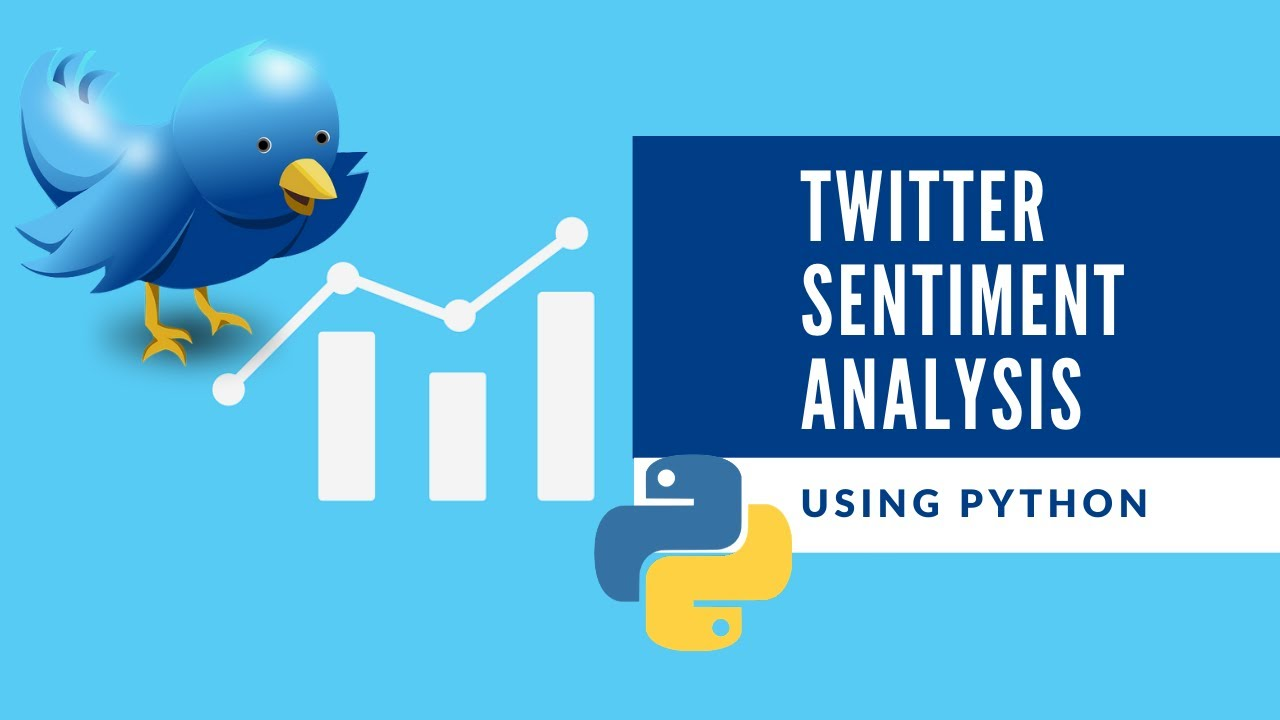

# A Twitter sentiment analysis determines negative, positive, neutral,or irrelevant emotions within the text of a tweet using NLP and ML models.
# The various columns present in this Twitter data are:
1.   target: the polarity of the tweet (positive or negative..etc)
2.   tweetid: Unique id of the tweet
3.   content: It refers to the text of the tweet



In [ ]:
# !pip install emoji

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Text processing
import nltk
from nltk.corpus import stopwords

# Download the 'punkt' tokenizer models
nltk.download('punkt')
nltk.download('stopwords')

import string
from nltk.stem import PorterStemmer

# Regular expression
import re

# Remove emoji
import emoji

# Wordcloud
from wordcloud import WordCloud
from collections import Counter

# Model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

def wrangle(training_path, validation_path):
    # Define the column names
    cols = ['tweetid', 'entity', 'target', 'content']

    # Load the datasets
    df0 = pd.read_csv(training_path, names=cols)
    df1 = pd.read_csv(validation_path, names=cols)

    # Concatenate the datasets
    twitter_data = pd.concat([df0, df1])


    # Displaying the initial observations
    print("Initial Observations:")
    print(twitter_data.head())
    print()


    # Conducting an examination of data types and missing values
    print("Info about data:")
    print(twitter_data.info(show_counts=True))
    print()

    # Check for duplicated rows
    print("Number of duplicated rows:", twitter_data.duplicated().sum())
    print()

    # Descriptive statistics
    print("Descriptive Statistics:")
    print(twitter_data.describe(include='all').transpose())
    print()

    #Drop unnecessary columns
    twitter_data.drop(columns=['tweetid', 'entity'], inplace=True)
    print("Columns with null values:")
    columns_with_null = twitter_data.columns[twitter_data.isnull().any()].tolist()
    print(columns_with_null)
    print()

    return twitter_data

# Example usage
training_path = "twitter_training.csv"
validation_path = "twitter_validation.csv"
data = wrangle(training_path, validation_path)

Initial Observations:
   tweetid       entity    target  \
0     2401  Borderlands  Positive   
1     2401  Borderlands  Positive   
2     2401  Borderlands  Positive   
3     2401  Borderlands  Positive   
4     2401  Borderlands  Positive   

                                             content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

Info about data:
<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweetid  75682 non-null  int64 
 1   entity   75682 non-null  object
 2   target   75682 non-null  object
 3   content  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB
None

Number of duplicated rows: 3

In [5]:
# drop null values
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.duplicated().sum()
data.isnull().sum()

target     0
content    0
dtype: int64

In [6]:
data.head()


,target,content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


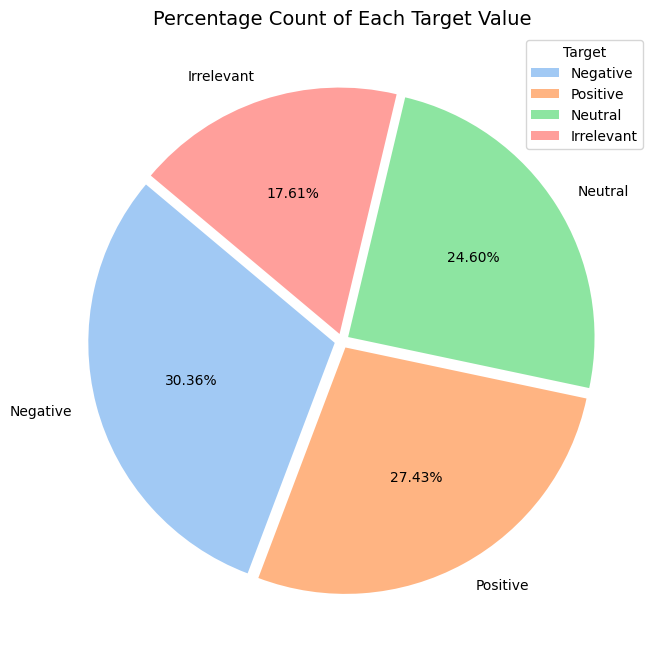

In [7]:
# Create a pie chart with value counts of the 'target' column
def plot_target_distribution(data):
    # Value counts of 'target' column
    target_counts = data['target'].value_counts()
    # Define color palette
    colors = sns.color_palette("pastel")
    # Explode the largest segment for better visibility
    explode = [0 if i == target_counts.idxmax() else 0.03 for i in range(len(target_counts))]
    # Plotting the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(target_counts, labels=target_counts.index, autopct='%.2f%%', colors=colors, startangle=140,explode=explode)
    plt.title("Percentage Count of Each Target Value", fontsize=14)

    # Add legend
    plt.legend(title="Target", labels=target_counts.index, loc="best")

    # Display the plot
    plt.show()

# Plot the target distribution
plot_target_distribution(data)

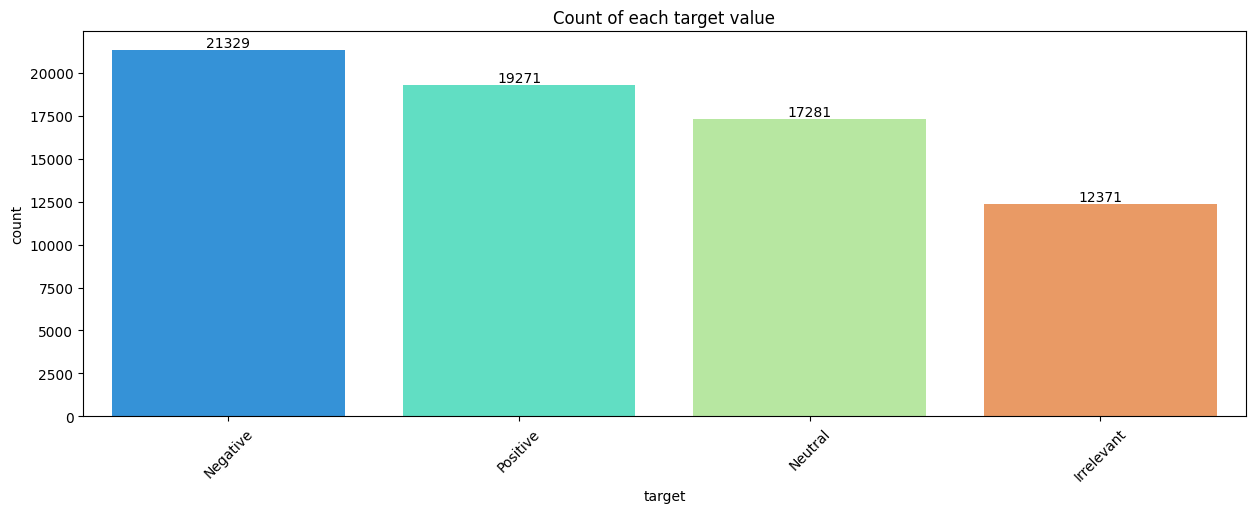

In [8]:
target_count = data['target'].value_counts().reset_index()
target_count
plt.figure(figsize=(15,5))
ax = sns.barplot(data=target_count,x='target',y='count',palette="rainbow")
for bars in ax.containers:
    ax.bar_label(bars)

plt.title("Count of each target value")
plt.xticks(rotation=45)

plt.show()

In [9]:
# char count
data['char_count'] = data['content'].apply(len)
# word count
data['word_count'] = data['content'].apply(lambda x:len(nltk.word_tokenize(x)))
# sentence count
data['sent_count'] = data['content'].apply(lambda x:len(nltk.sent_tokenize(x)))

# visualize the distribution of three different text-related metrics—character count, word count, and sentence count

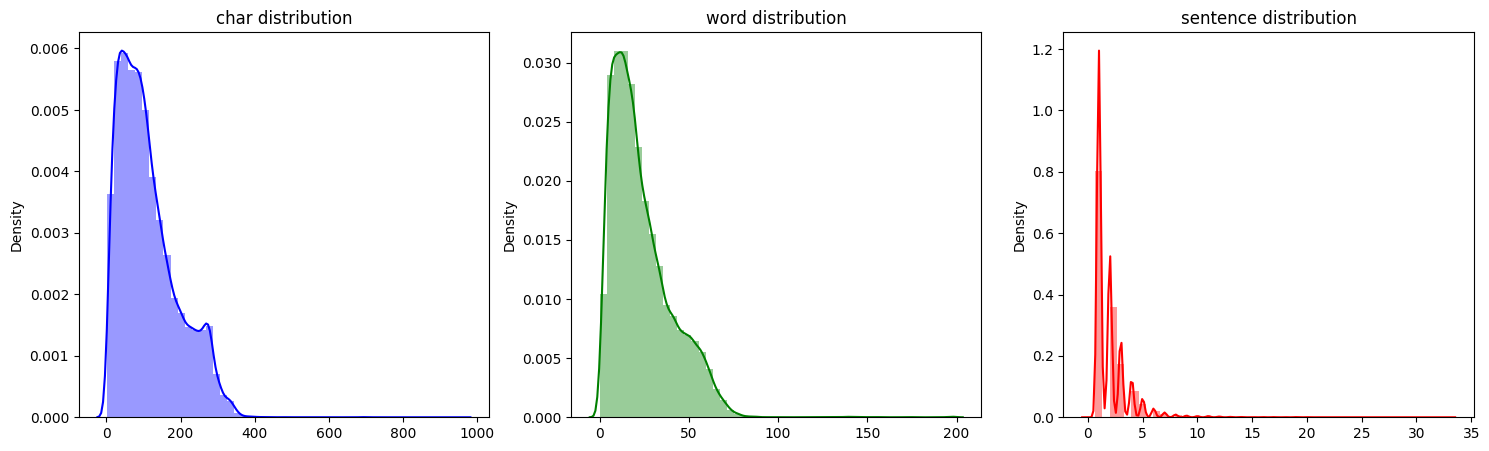

In [10]:
# dist plot

fig, axes = plt.subplots(1,3,figsize=(18,5))
sns.distplot(ax=axes[0],x=data['char_count'],color='b')
axes[0].set_title('char distribution')

sns.distplot(ax=axes[1],x=data['word_count'],color='g')
axes[1].set_title('word distribution')

sns.distplot(ax=axes[2],x=data['sent_count'],color='r')
axes[2].set_title('sentence distribution')
plt.show()

In [11]:
data['content'] = data['content'].apply(lambda x: emoji.replace_emoji(x,replace=''))
data.head()


,target,content,char_count,word_count,sent_count
0,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,Positive,I am coming to the borders and I will kill you...,51,13,1
2,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,Positive,im coming on borderlands and i will murder you...,51,11,1
4,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


# Text Preprocessing

1.   lowercase
2.   remove punctuation
3.   remove stopwords
4.   steaming


In [12]:
# function for text preprocessing
ps = PorterStemmer()   #implementation of the Porter stemming algorithm provided by NLTK.

def preprocessing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    full_txt = []
    for i in text:
        if i not in string.punctuation and i not in stopwords.words('english'):
            full_txt.append(ps.stem(i))
    return ' '.join(full_txt)

data['content'] = data['content'].apply(preprocessing)


In [13]:
data.head()

,target,content,char_count,word_count,sent_count
0,Positive,im get borderland murder,53,11,1
1,Positive,come border kill,51,13,1
2,Positive,im get borderland kill,50,11,1
3,Positive,im come borderland murder,51,11,1
4,Positive,im get borderland 2 murder,57,13,1


In [14]:
data.duplicated().sum()
data = data.drop_duplicates()

**word cloud for (positive, negative, neutral, irrelevant) tweets**

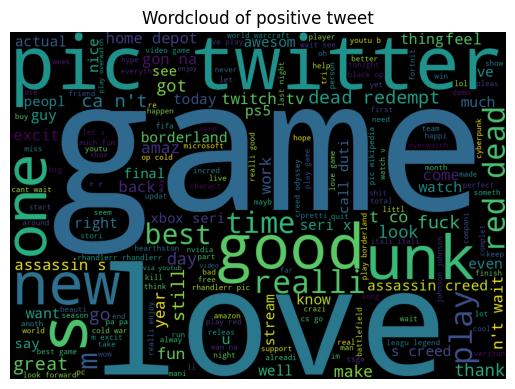

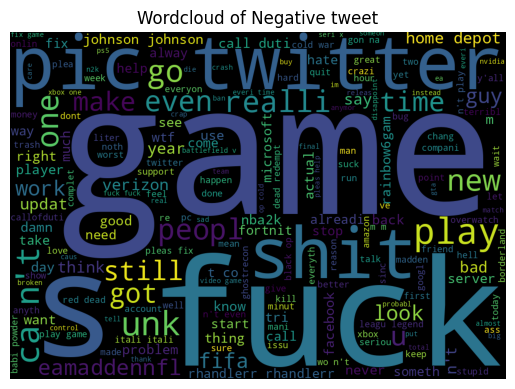

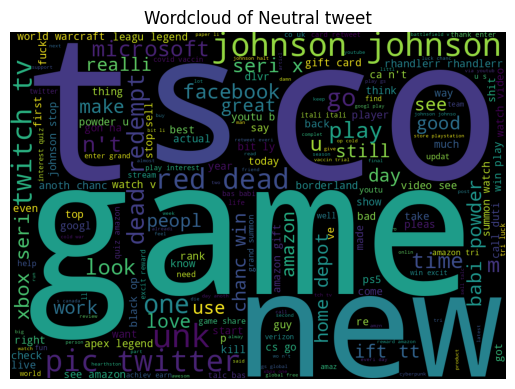

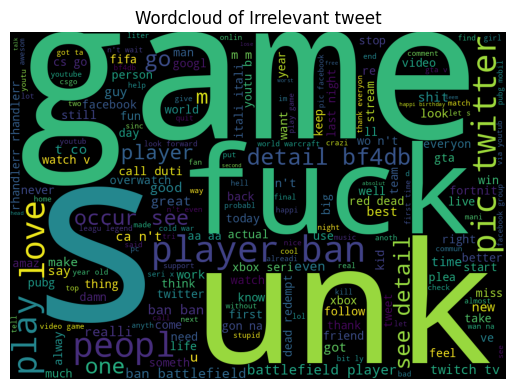

In [15]:
# word cloud for positive tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
positive = wc.generate(data[data['target']=='Positive']['content'].str.cat(sep=" "))
plt.title('Wordcloud of positive tweet')
plt.axis('off')
plt.imshow(positive)
plt.show()

# word cloud for negative tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
negative = wc.generate(data[data['target']=='Negative']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Negative tweet')
plt.axis('off')
plt.imshow(negative)
plt.show()

# word cloud for neutral tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
neutral = wc.generate(data[data['target']=='Neutral']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Neutral tweet')
plt.axis('off')
plt.imshow(neutral)
plt.show()

# word cloud for irrelevant tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
irrelevant = wc.generate(data[data['target']=='Irrelevant']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Irrelevant tweet')
plt.axis('off')
plt.imshow(irrelevant)
plt.show()

**visualize the frequency of the 50 most common words found in positive tweets.**




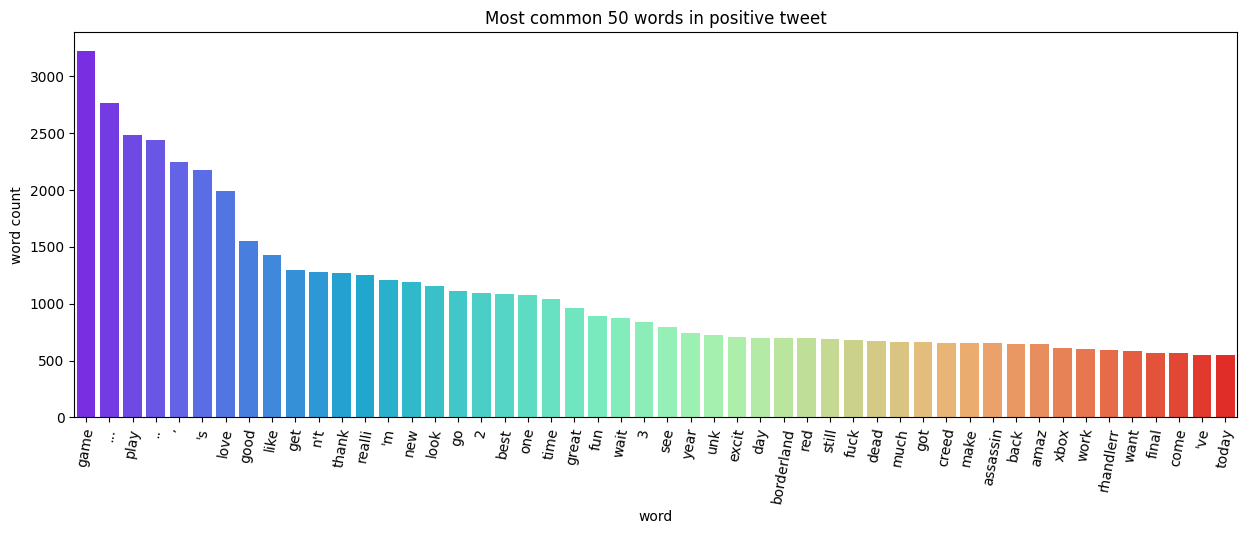

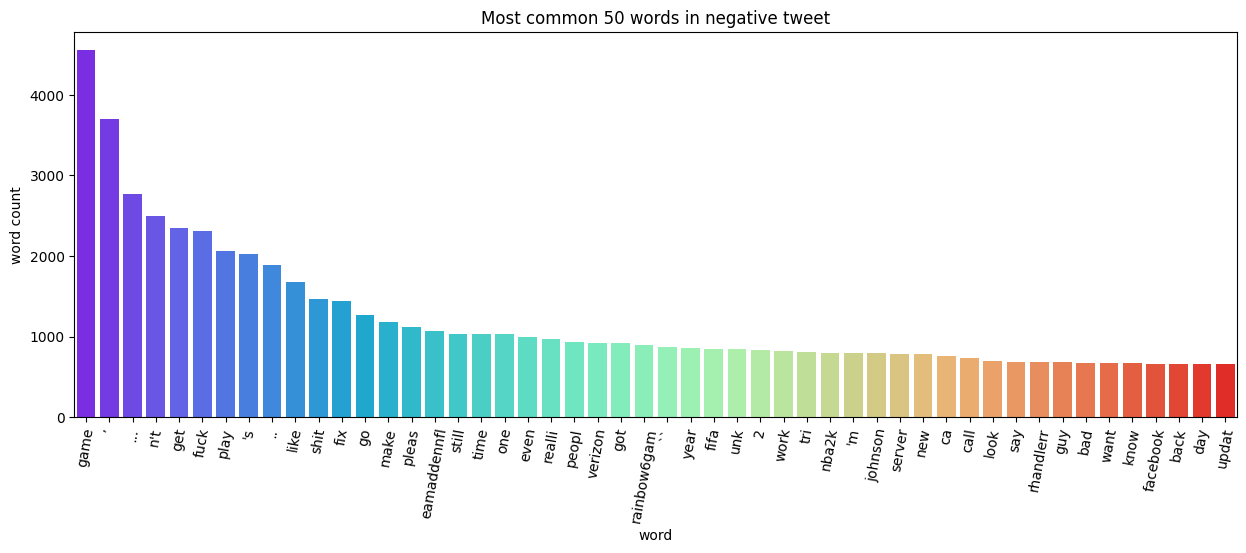

In [16]:
# most common words in positive tweets
positive = []
for txt in data[data['target']=='Positive']['content'].tolist():
    for word in txt.split():
        positive.append(word)
# plot most 50 common words from positive tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(positive).most_common(50))[0],y=pd.DataFrame(Counter(positive).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in positive tweet')
plt.xticks(rotation=80)
plt.show()

# most common words in negative tweets
negative = []
for txt in data[data['target']=='Negative']['content'].tolist():
    for word in txt.split():
        negative.append(word)
# plot most 50 common words from negative tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(negative).most_common(50))[0],y=pd.DataFrame(Counter(negative).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in negative tweet')
plt.xticks(rotation=80)
plt.show()

# **Build Model pipline**

1.  step-1 convert text data into numeric
2.  step-2 apply RandomForestClassifier




In [17]:
# convert Positive to 1
# convert Negative to 0
# convert Neutral to 2
# convert Irrelevant to 3
data['sentiment'] = data['target'].replace({'Positive':1,'Negative':0,'Neutral':2,'Irrelevant':3})
X = data['content']
y = data['sentiment']

# split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

sentiment_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('rfc',RandomForestClassifier(random_state=42))
])
# fit the data into pipeline
sentiment_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(random_state=42))])

In [18]:
y_pred = sentiment_pipeline.predict(X_test)
accuracy_score_RN= accuracy_score(y_test,y_pred).round(4)
print(accuracy_score(y_test,y_pred).round(4))

0.9326


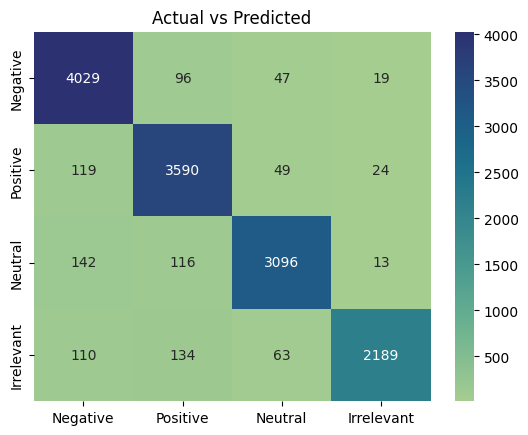

In [19]:
label = ['Negative','Positive','Neutral','Irrelevant']
sns.heatmap(confusion_matrix(y_test,y_pred),xticklabels=label,yticklabels=label,annot=True,fmt='d',cmap='crest')
plt.title('Actual vs Predicted')
plt.show()

# **Build Model pipline**

1.  step-1 convert text data into numeric
2.  step-2 apply LogisticRegression




In [20]:
lr_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('lr',LogisticRegression(penalty=None,solver='sag',max_iter=500))
])
lr_pipeline.fit(X_train,y_train)
lr_pred = lr_pipeline.predict(X_test)
accuracy_score_lr = accuracy_score(y_test,lr_pred).round(4)
print(accuracy_score(y_test,lr_pred).round(4))

0.8398


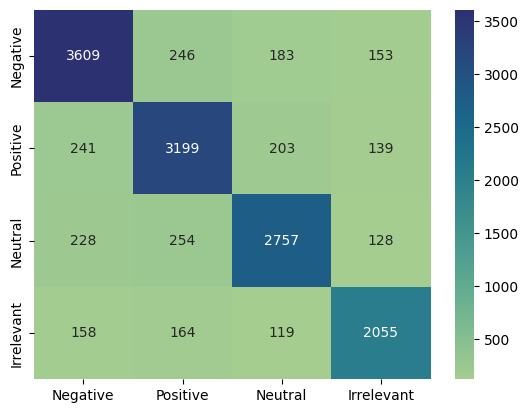

In [21]:
label = ['Negative','Positive','Neutral','Irrelevant']
sns.heatmap(confusion_matrix(y_test,lr_pred),xticklabels=label,yticklabels=label,annot=True,fmt='d',cmap='crest')
plt.show()

In [22]:
models = pd.DataFrame({
    'Model': ['RandomForest Classifier','Logistic Regression'],
    'Score': [accuracy_score_RN, accuracy_score_lr]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,RandomForest Classifier,0.9326
1,Logistic Regression,0.8398
